# Analyzing GRB 080916C
![Alt text](https://astrobites.org/wp-content/uploads/2014/10/NASAGRBwhoa-1024x576.jpg)
*(NASA/Swift/Cruz deWilde)*

To demonstrate the capabilities and features of 3ML in, we will go through a time-integrated and time-resolved analysis. This example serves as a standard way to analyze Fermi-GBM data with 3ML as well as a template for how you can design your instrument's analysis pipeline with 3ML if you have similar data.

3ML provides utilities to reduce time series data to plugins in a *correct* and *statistically justified* way (e.g., background fitting of Poisson data is done with a Poisson likelihood). The approach is generic and can be extended. For more details, see the [time series documentation](https://threeml.readthedocs.io/en/stable/notebooks/Building_Plugins_from_TimeSeries.html).

In [1]:
import warnings

warnings.simplefilter("ignore")

In [2]:
%%capture
import matplotlib.pyplot as plt
import numpy as np

np.seterr(all="ignore")


from threeML import *
from threeML.io.package_data import get_path_of_data_file

In [3]:

silence_warnings()
%matplotlib inline
from jupyterthemes import jtplot

jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
set_threeML_style()

## Examining the catalog

As with Swift and Fermi-LAT, 3ML provides a simple interface to the on-line Fermi-GBM catalog. Let's get the information for GRB 080916C.

In [4]:
gbm_catalog = FermiGBMBurstCatalog()
gbm_catalog.query_sources("GRB080916009")

00:49:11 INFO      The cache for fermigbrst does not yet exist. We will try to    ]8;id=576834;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=520656;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#64\64]8;;\
                  build it                                                                                         
                                                                                                                   

         INFO      Building cache for fermigbrst                                 ]8;id=859156;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=900527;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#112\112]8;;\

<Table length=1>
    name        ra     dec    trigger_time   t90  
   object    float64 float64    float64    float64
------------ ------- ------- ------------- -------
GRB080916009 119.800 -56.600 54725.0088613  62.977

To aid in quickly replicating the catalog analysis, and thanks to the tireless efforts of the Fermi-GBM team, we have added the ability to extract the analysis parameters from the catalog as well as build an **astromodels** model with the best fit parameters baked in. Using this information, one can quickly run through the catalog an replicate the entire analysis with a script. Let's give it a try.

In [5]:
grb_info = gbm_catalog.get_detector_information()["GRB080916009"]

gbm_detectors = grb_info["detectors"]
source_interval = grb_info["source"]["fluence"]
background_interval = grb_info["background"]["full"]
best_fit_model = grb_info["best fit model"]["fluence"]
model = gbm_catalog.get_model(best_fit_model, "fluence")["GRB080916009"]

In [6]:
model

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (5):
--------------------

                                value min_value max_value            unit
GRB080916009...K             0.012255       0.0      None  keV-1 s-1 cm-2
GRB080916009...alpha        -1.130424      -1.5       2.0                
GRB080916009...break_energy  309.2031      10.0      None             keV
GRB080916009...break_scale        0.3       0.0      10.0                
GRB080916009...beta         -2.096931      -5.0      -1.6                

Fixed parameters (3):
(abridged. Use complete=True to see all fixed parameters)


Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

## Downloading the data
We provide a simple interface to download the Fermi-GBM data. Using the information from the catalog that we have extracted, we can download just the data from the detectors that were used for the catalog analysis. This will download the CSPEC, TTE and instrument response files from the on-line database.



In [7]:
dload = download_GBM_trigger_data("bn080916009", detectors=gbm_detectors)

Let's first examine the catalog fluence fit. Using the **TimeSeriesBuilder**, we can fit the background, set the source interval, and create a 3ML plugin for the analysis. We will loop through the detectors, set their appropriate channel selections, and ensure there are enough counts in each bin to make the [PGStat profile likelihood valid](https://giacomov.github.io/Bias-in-profile-poisson-likelihood/).

* First we use the CSPEC data to fit the background using the background selections. We use CSPEC because it has a longer duration for fitting the background.
* The background is saved to an HDF5 file that stores the polynomial coefficients and selections which we can read in to the TTE file later.
* The light curve is plotted.
* The source selection from the catalog is set and **DispersionSpectrumLike** plugin is created.
* The plugin has the standard GBM channel selections for spectral analysis set.

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

00:50:13 INFO      Auto-determined polynomial order: 0                                ]8;id=902098;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=679941;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_03 background:   0%|          | 0/128 [00:00<?, ?it/s]

00:50:31 INFO      None 0-order polynomial fit with the mle method                               ]8;id=30595;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=44950;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n3_bkg.h5                                         ]8;id=978941;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=579064;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n3_bkg.h5                                         ]8;id=77586;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=733957;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n3_bkg.h5                              ]8;id=167605;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=932003;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=763302;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=104507;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=117012;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=93469;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#485\485]8;;\

         INFO      - observation: poisson                                                       ]8;id=875438;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=26358;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#486\486]8;;\

         INFO      - background: gaussian                                                       ]8;id=468978;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=961528;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#487\487]8;;\

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=694375;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=556652;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

00:50:35 INFO      Now using 120 bins                                                          ]8;id=58689;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=17703;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

00:50:37 INFO      Auto-determined polynomial order: 1                                ]8;id=65735;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=887901;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_04 background:   0%|          | 0/128 [00:00<?, ?it/s]

00:50:56 INFO      None 1-order polynomial fit with the mle method                               ]8;id=693401;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=378778;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n4_bkg.h5                                         ]8;id=463716;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=561230;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n4_bkg.h5                                         ]8;id=17802;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=132662;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

00:50:57 INFO      Successfully restored fit from n4_bkg.h5                              ]8;id=389866;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=827664;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=633879;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=990540;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=176569;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=907147;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#485\485]8;;\

         INFO      - observation: poisson                                                       ]8;id=415569;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=652989;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#486\486]8;;\

         INFO      - background: gaussian                                                       ]8;id=347182;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=540954;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#487\487]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=275067;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=358676;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=240705;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=136104;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

00:50:59 INFO      Auto-determined polynomial order: 1                                ]8;id=50456;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=350258;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_BGO_00 background:   0%|          | 0/128 [00:00<?, ?it/s]

00:51:19 INFO      None 1-order polynomial fit with the mle method                               ]8;id=625014;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=770070;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=793586;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=63325;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=292536;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=218561;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

00:51:20 INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=9434;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=246026;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=252901;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=102552;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=670944;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=901110;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#485\485]8;;\

         INFO      - observation: poisson                                                       ]8;id=694920;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=922526;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#486\486]8;;\

         INFO      - background: gaussian                                                       ]8;id=625557;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=854320;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#487\487]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=331983;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=69844;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=642353;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=304131;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

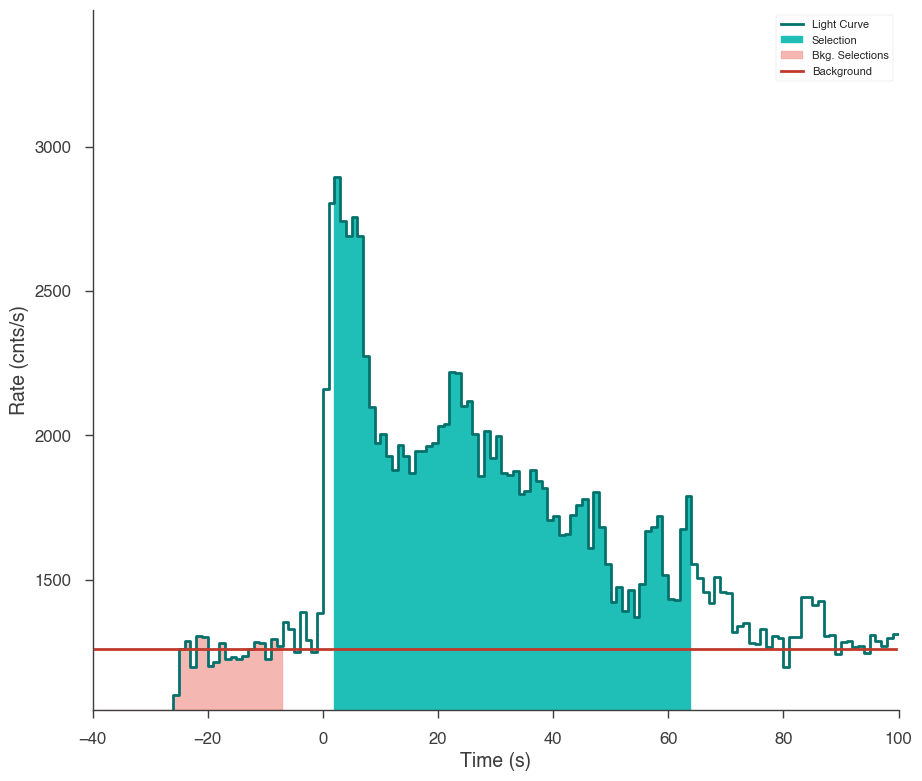

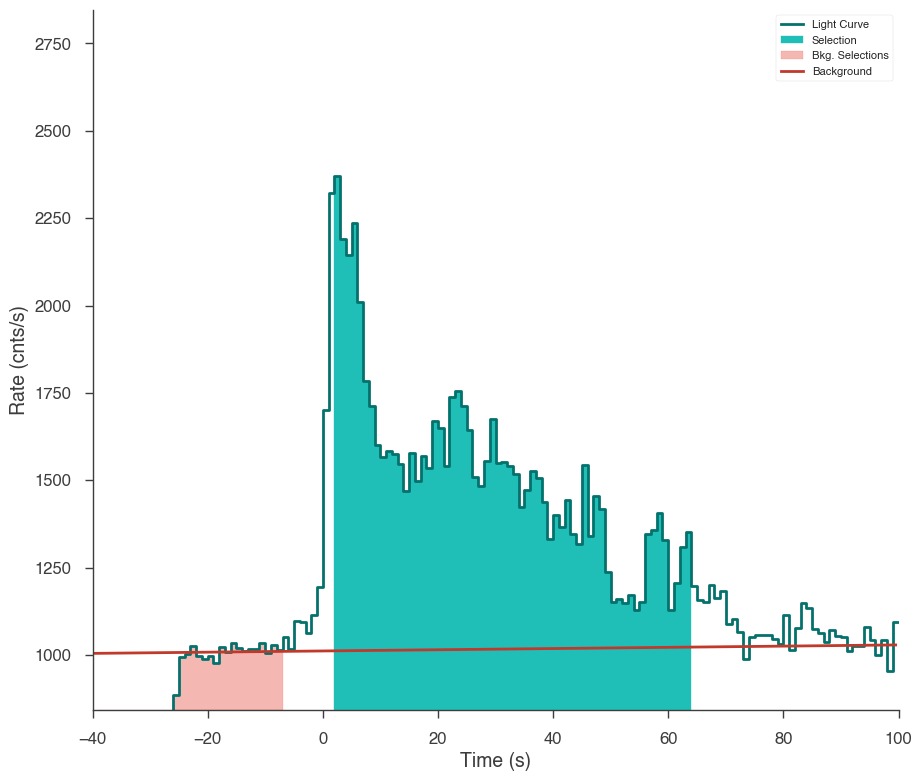

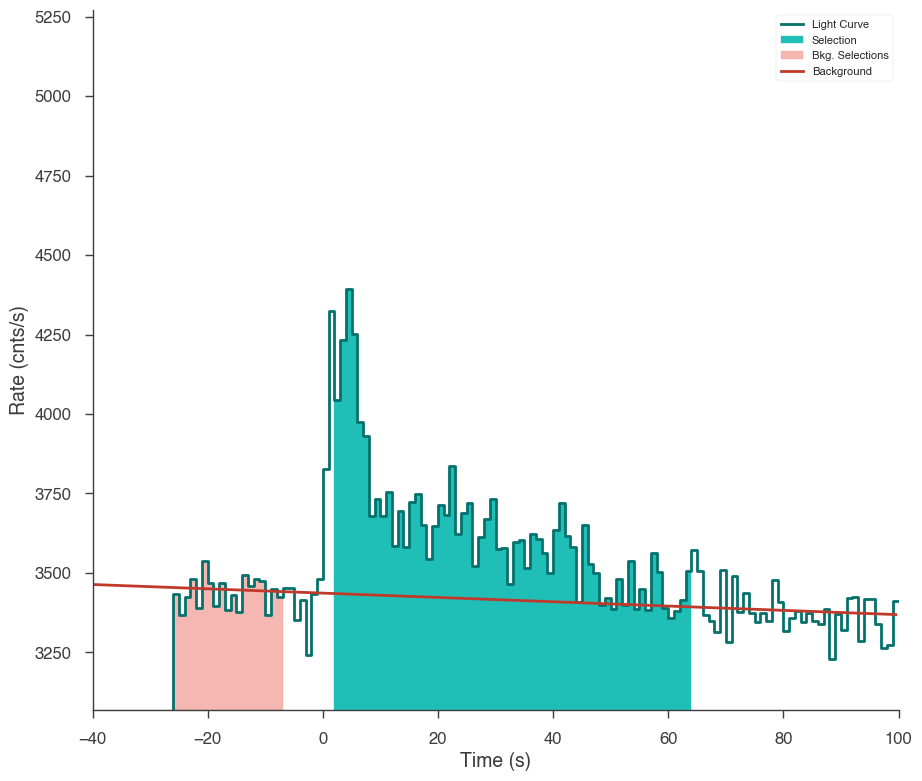

In [8]:
fluence_plugins = []
time_series = {}
for det in gbm_detectors:

    ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
        det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"]
    )

    ts_cspec.set_background_interval(*background_interval.split(","))
    ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

    ts_tte = TimeSeriesBuilder.from_gbm_tte(
        det,
        tte_file=dload[det]["tte"],
        rsp_file=dload[det]["rsp"],
        restore_background=f"{det}_bkg.h5",
    )

    time_series[det] = ts_tte

    ts_tte.set_active_time_interval(source_interval)

    ts_tte.view_lightcurve(-40, 100)

    fluence_plugin = ts_tte.to_spectrumlike()

    if det.startswith("b"):

        fluence_plugin.set_active_measurements("250-30000")

    else:

        fluence_plugin.set_active_measurements("9-900")

    fluence_plugin.rebin_on_background(1.0)

    fluence_plugins.append(fluence_plugin)

## Setting up the fit
Let's see if we can reproduce the results from the catalog.

### Set priors for the model
We will fit the spectrum using Bayesian analysis, so we must set priors on the model parameters.


In [9]:
model.GRB080916009.spectrum.main.shape.alpha.prior = Truncated_gaussian(
    lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.beta.prior = Truncated_gaussian(
    lower_bound=-5, upper_bound=-1.6, mu=-2.25, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.break_energy.prior = Log_normal(mu=2, sigma=1)
model.GRB080916009.spectrum.main.shape.break_energy.bounds = (None, None)
model.GRB080916009.spectrum.main.shape.K.prior = Log_uniform_prior(
    lower_bound=1e-3, upper_bound=1e1
)
model.GRB080916009.spectrum.main.shape.break_scale.prior = Log_uniform_prior(
    lower_bound=1e-4, upper_bound=10
)

### Clone the model and setup the Bayesian analysis class
Next, we clone the model we built from the catalog so that we can look at the results later and fit the cloned model. We pass this model and the **DataList** of the plugins to a **BayesianAnalysis** class and set the sampler to MultiNest.

In [10]:
new_model = clone_model(model)

bayes = BayesianAnalysis(new_model, DataList(*fluence_plugins))

# share spectrum gives a linear speed up when
# spectrumlike plugins have the same RSP input energies
bayes.set_sampler("multinest", share_spectrum=True)

00:51:21 INFO      sampler set to multinest                                                ]8;id=918636;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=438027;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

### Examine at the catalog fitted model
We can quickly examine how well the catalog fit matches the data. There appears to be a discrepancy between the data and the model! Let's refit to see if we can fix it.

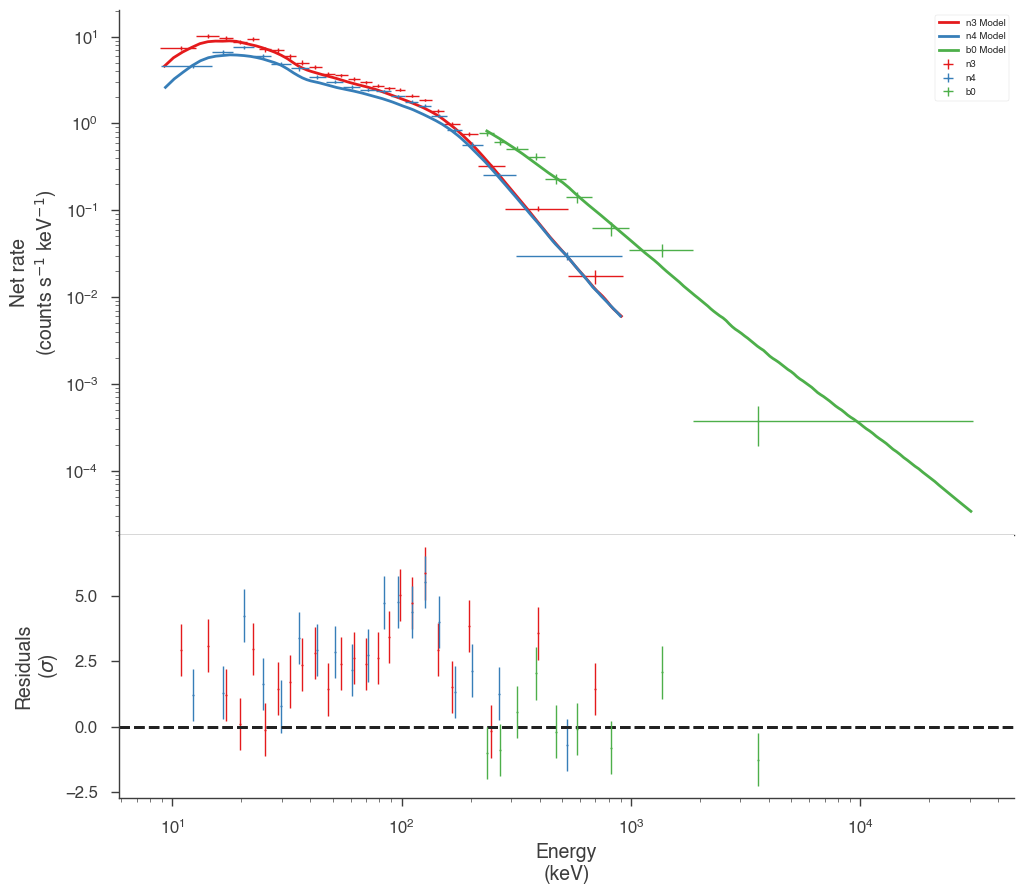

In [11]:
fig = display_spectrum_model_counts(bayes, min_rate=20, step=False)

### Run the sampler
We let MultiNest condition the model on the data

In [12]:
bayes.sampler.setup(n_live_points=400)
bayes.sample()

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    5
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -3119.8422322666083      +/-  0.25486045170955401     
 Total Likelihood Evaluations:        26332
 Sampling finished. Exiting MultiNest



00:51:56 INFO      fit restored to maximum of posterior                                         ]8;id=174090;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=620671;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=209866;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=570178;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                    
GRB080916009...K             (1.4961 -0.024 +0.0032) x 10^-2  1 / (cm2 keV s)
GRB080916009...alpha            (-9.904 +0.018 +0.8) x 10^-1                 
GRB080916009...break_energy        (1.86 -0.14 +0.05) x 10^2              keV
GRB080916009...break_scale         (4.03 +0.09 +2.2) x 10^-1                 
GRB080916009...beta                      -1.979 -0.05 +0.028

Values of -log(posterior) at the minimum:

-log(posterior)
b0        -1058.336112
n3        -1030.147507
n4        -1020.142670
total     -3108.626290

Values of statistical measures:

statistical measures
AIC              6227.423034
BIC              6246.655244
DIC              6202.774794
PDIC                1.789197
log(Z)          -1354.930266

Now our model seems to match much better with the data!

         INFO      fit restored to median of posterior                                          ]8;id=808847;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=883577;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

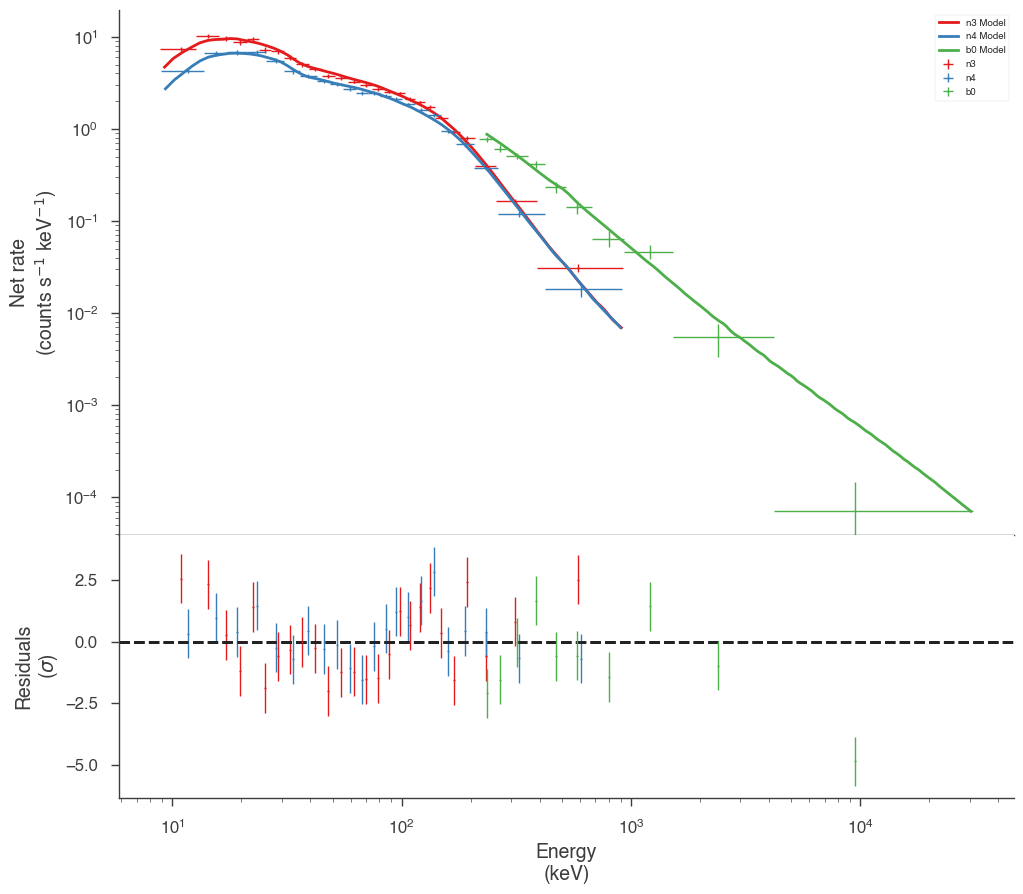

In [13]:
bayes.restore_median_fit()
fig = display_spectrum_model_counts(bayes, min_rate=20)

But how different are we from the catalog model? Let's plot our fit along with the catalog model. Luckily, 3ML can handle all the units for is

In [14]:
conversion = u.Unit("keV2/(cm2 s keV)").to("erg2/(cm2 s keV)")
energy_grid = np.logspace(1, 4, 100) * u.keV
vFv = (energy_grid**2 * model.get_point_source_fluxes(0, energy_grid)).to(
    "erg2/(cm2 s keV)"
)

processing Bayesian analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

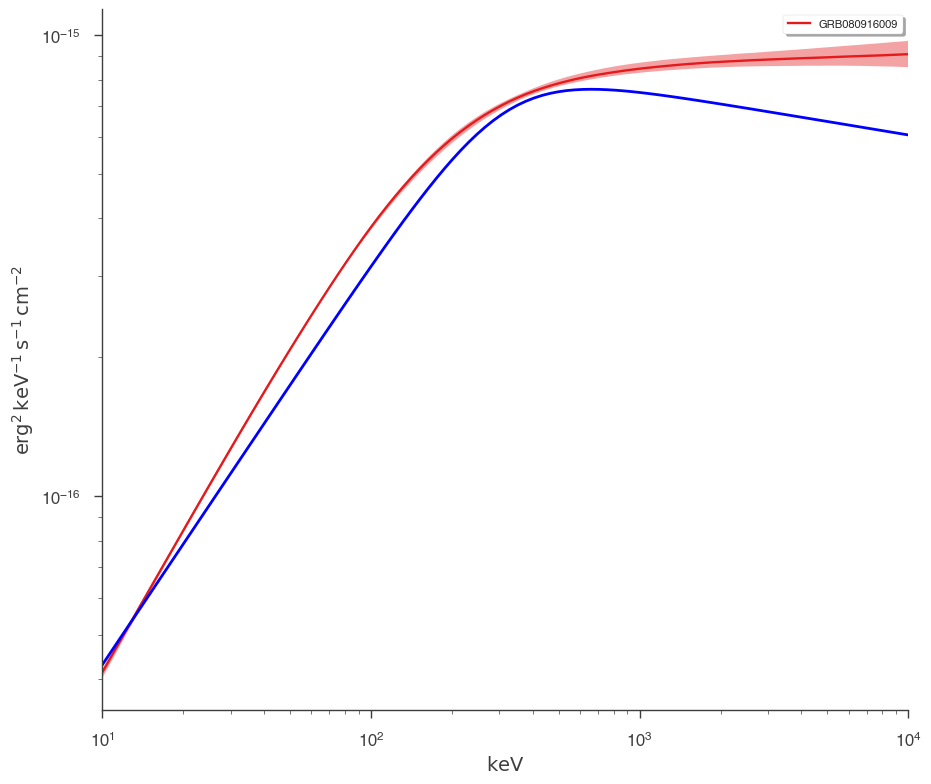

In [15]:
fig = plot_spectra(bayes.results, flux_unit="erg2/(cm2 s keV)")
ax = fig.get_axes()[0]
_ = ax.loglog(energy_grid, vFv, color="blue", label="catalog model")

## Time Resolved Analysis

Now that we have examined fluence fit, we can move to performing a time-resolved analysis.

### Selecting a temporal binning

We first get the brightest NaI detector and create time bins via the Bayesian blocks algorithm. We can use the fitted background to make sure that our intervals are chosen in an unbiased way.

In [16]:
n3 = time_series["n3"]

In [17]:
n3.create_time_bins(0, 60, method="bayesblocks", use_background=True, p0=0.2)

00:54:36 INFO      Created 15 bins via bayesblocks                                       ]8;id=993710;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=983444;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Sometimes, glitches in the GBM data cause spikes in the data that the Bayesian blocks algorithm detects as fast changes in the count rate. We will have to remove those intervals manually.

<div class="alert alert-info">

**Note:** In the future, 3ML will provide an automated method to remove these unwanted spikes.

</div>


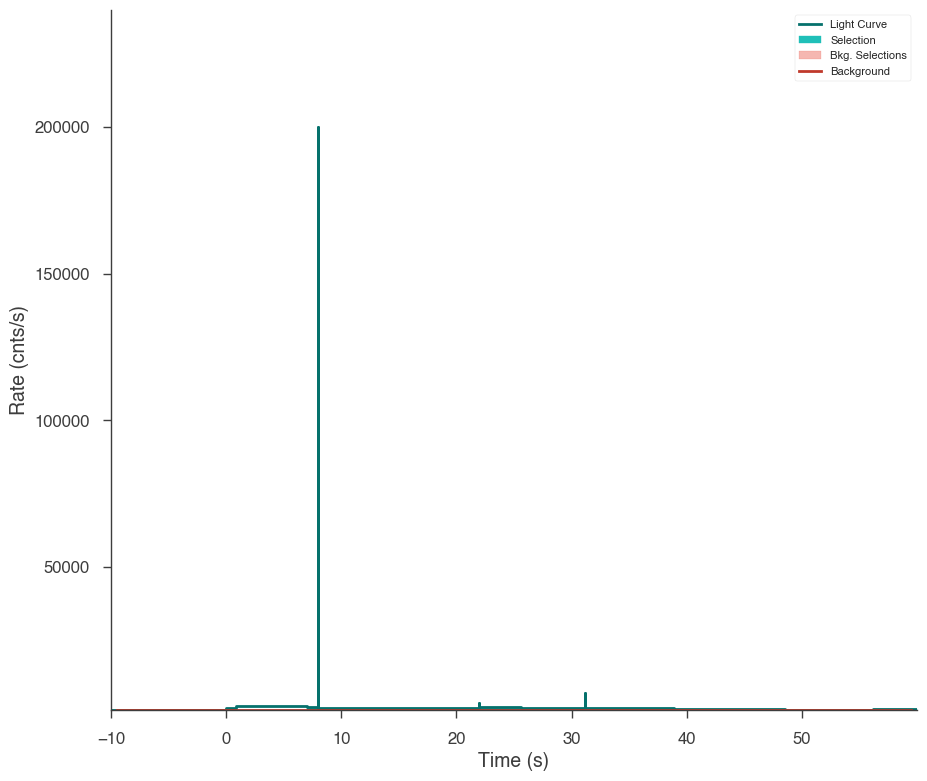

In [18]:
fig = n3.view_lightcurve(use_binner=True)

In [19]:
bad_bins = []
for i, w in enumerate(n3.bins.widths):

    if w < 5e-2:
        bad_bins.append(i)


edges = [n3.bins.starts[0]]

for i, b in enumerate(n3.bins):

    if i not in bad_bins:
        edges.append(b.stop)

starts = edges[:-1]
stops = edges[1:]


n3.create_time_bins(starts, stops, method="custom")

         INFO      Created 12 bins via custom                                            ]8;id=959205;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=786859;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Now our light curve looks much more acceptable.

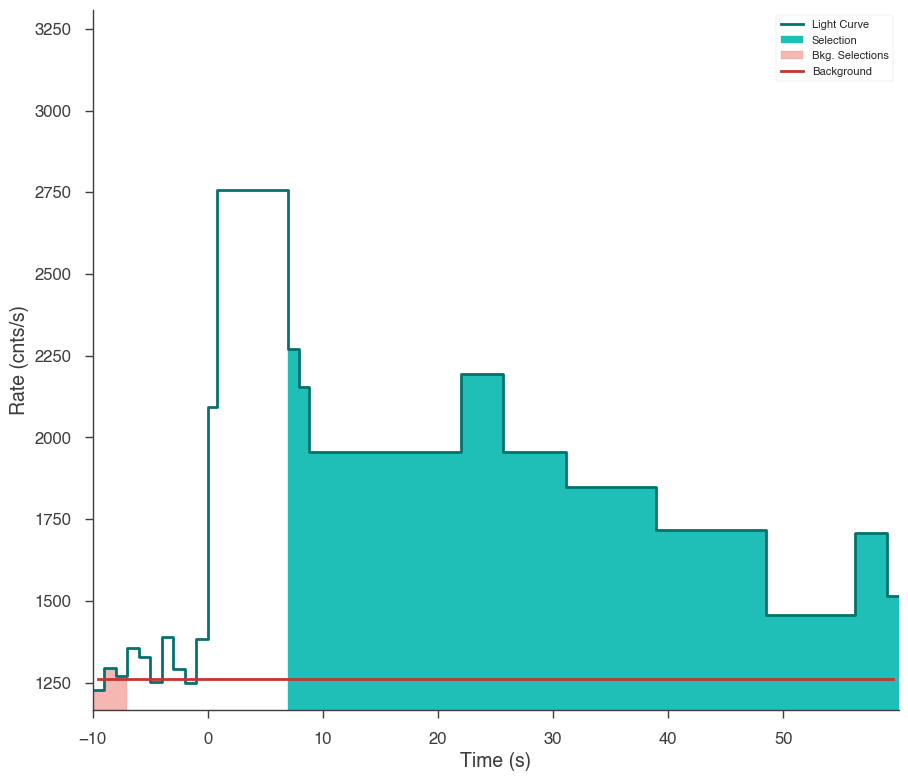

In [20]:
fig = n3.view_lightcurve(use_binner=True)

The time series objects can read time bins from each other, so we will map these time bins onto the other detectors' time series and create a list of time plugins for each detector and each time bin created above.

In [21]:
time_resolved_plugins = {}

for k, v in time_series.items():
    v.read_bins(n3)
    time_resolved_plugins[k] = v.to_spectrumlike(from_bins=True)

00:54:37 INFO      Created 12 bins via custom                                            ]8;id=660495;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=204438;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

         INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=842187;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=410511;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Created 12 bins via custom                                            ]8;id=35973;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=707510;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

00:54:38 INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=14954;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=383299;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Created 12 bins via custom                                            ]8;id=864140;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=878690;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

00:54:39 INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=475898;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=953347;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

### Setting up the model
For the time-resolved analysis, we will fit the classic *Band* function to the data. We will set some principled priors.

In [22]:
band = Band()
band.alpha.prior = Truncated_gaussian(lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5)
band.beta.prior = Truncated_gaussian(lower_bound=-5, upper_bound=-1.6, mu=-2, sigma=0.5)
band.xp.prior = Log_normal(mu=2, sigma=1)
band.xp.bounds = (None, None)
band.K.prior = Log_uniform_prior(lower_bound=1e-10, upper_bound=1e3)
ps = PointSource("grb", 0, 0, spectral_shape=band)
band_model = Model(ps)

### Perform the fits

One way to perform Bayesian spectral fits to all the intervals is to loop through each one. There can are many ways to do this, so find an analysis pattern that works for you.



In [23]:
models = []
results = []
analysis = []
for interval in range(12):

    # clone the model above so that we have a separate model
    # for each fit

    this_model = clone_model(band_model)

    # for each detector set up the plugin
    # for this time interval

    this_data_list = []
    for k, v in time_resolved_plugins.items():

        pi = v[interval]

        if k.startswith("b"):
            pi.set_active_measurements("250-30000")
        else:
            pi.set_active_measurements("9-900")

        pi.rebin_on_background(1.0)

        this_data_list.append(pi)

    # create a data list

    dlist = DataList(*this_data_list)

    # set up the sampler and fit

    bayes = BayesianAnalysis(this_model, dlist)

    # get some speed with share spectrum
    bayes.set_sampler("multinest", share_spectrum=True)
    bayes.sampler.setup(n_live_points=500)
    bayes.sample()

    # at this stage we coudl also
    # save the analysis result to
    # disk but we will simply hold
    # onto them in memory

    analysis.append(bayes)

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=985582;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=524696;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=677672;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=6471;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=20749;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=50886;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=67744;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=374439;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=555168;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=951267;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 107 bins                                                          ]8;id=394789;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=920344;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=781146;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=92334;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -788.24565802162931      +/-  0.17619060446523693     
 Total Likelihood Evaluations:        17202
 Sampling finished. Exiting MultiNest



00:54:58 INFO      fit restored to maximum of posterior                                         ]8;id=696045;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=382295;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=886148;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=257933;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                              
grb.spectrum.main.Band.K       (3.6 -0.7 +0.5) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-5.4 -1.6 +1.1) x 10^-1                 
grb.spectrum.main.Band.xp     (3.10 -0.34 +1.1) x 10^2              keV
grb.spectrum.main.Band.beta           -2.08 -0.4 +0.09

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval0      -285.678453
n3_interval0      -250.091775
n4_interval0      -268.053395
total             -803.823623

Values of statistical measures:

statistical measures
AIC              1615.760561
BIC              1631.169378
DIC              1570.359376
PDIC                2.040974
log(Z)           -342.330740

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=905037;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=807217;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=224900;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=733426;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=504111;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=577257;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=135078;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=845195;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=502648;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=779518;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=298671;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=152428;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=578093;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=411254;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1943.2616416352071      +/-  0.21256259208082934     
 Total Likelihood Evaluations:        23907
 Sampling finished. Exiting MultiNest



00:55:24 INFO      fit restored to maximum of posterior                                         ]8;id=82575;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=313037;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=966180;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=546724;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                 
grb.spectrum.main.Band.K       (4.11 -0.12 +0.16) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-8.60 -0.25 +0.29) x 10^-1                 
grb.spectrum.main.Band.xp          (6.2 -0.5 +0.6) x 10^2              keV
grb.spectrum.main.Band.beta             -2.14 -0.12 +0.07

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval1      -673.732545
n3_interval1      -642.012744
n4_interval1      -645.449573
total            -1961.194863

Values of statistical measures:

statistical measures
AIC              3930.503040
BIC              3945.911858
DIC              3873.348246
PDIC                3.646864
log(Z)           -843.947808

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=430902;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=196312;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=600080;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=355919;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=851847;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=747440;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=108694;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=602887;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=466365;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=12833;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 115 bins                                                          ]8;id=165052;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=63124;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=898714;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=910544;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -907.12082075270234      +/-  0.19616356085578379     
 Total Likelihood Evaluations:        20382
 Sampling finished. Exiting MultiNest



00:55:47 INFO      fit restored to maximum of posterior                                         ]8;id=740382;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=183032;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=586242;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=627419;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (2.47 -0.07 +0.34) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha         -1.062 -0.024 +0.11                 
grb.spectrum.main.Band.xp         (6.4 -1.7 +1.2) x 10^2              keV
grb.spectrum.main.Band.beta          -1.967 -0.26 +0.006

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval2      -324.769865
n3_interval2      -289.423986
n4_interval2      -312.663083
total             -926.856935

Values of statistical measures:

statistical measures
AIC              1861.827185
BIC              1877.236003
DIC              1804.530813
PDIC                1.885568
log(Z)           -393.957567

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=967943;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=61682;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=853846;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=158935;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=589135;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=956717;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=338598;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=632395;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=113434;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=271956;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 109 bins                                                          ]8;id=645857;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=288674;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=852705;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=844323;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -788.91262779453507      +/-  0.18251137513796931     
 Total Likelihood Evaluations:        16758
 Sampling finished. Exiting MultiNest



00:56:06 INFO      fit restored to maximum of posterior                                         ]8;id=165892;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=868050;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=290462;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=252602;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (2.82 -0.25 +0.29) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha    (-9.5 -0.7 +0.6) x 10^-1                 
grb.spectrum.main.Band.xp         (3.6 -0.6 +0.7) x 10^2              keV
grb.spectrum.main.Band.beta           -2.197 -0.6 +0.034

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval3      -298.555868
n3_interval3      -242.657931
n4_interval3      -262.560079
total             -803.773878

Values of statistical measures:

statistical measures
AIC              1615.661070
BIC              1631.069887
DIC              1570.463523
PDIC                2.762801
log(Z)           -342.620401

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=612675;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=49083;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=276269;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=117943;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=849683;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=605507;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=507982;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=310084;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=55491;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=800388;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=658558;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=395383;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=679224;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=252780;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -2270.4995795525906      +/-  0.19695884733418909     
 Total Likelihood Evaluations:        23302
 Sampling finished. Exiting MultiNest



00:56:31 INFO      fit restored to maximum of posterior                                         ]8;id=681301;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=322510;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=171470;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=12853;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (2.03 -0.11 +0.12) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha      (-9.9 +/- 0.4) x 10^-1                 
grb.spectrum.main.Band.xp         (4.1 -0.5 +0.6) x 10^2              keV
grb.spectrum.main.Band.beta            -1.98 -0.12 +0.07

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval4      -778.646222
n3_interval4      -757.138337
n4_interval4      -746.857120
total            -2282.641679

Values of statistical measures:

statistical measures
AIC              4573.396673
BIC              4588.805491
DIC              4528.091808
PDIC                3.530789
log(Z)           -986.065439

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=298524;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=265372;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=361620;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=512351;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=731685;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=557188;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=934313;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=699761;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=636825;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=191709;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=856061;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=247408;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=760155;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=217307;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1574.2212402164494      +/-  0.19644730745976111     
 Total Likelihood Evaluations:        17827
 Sampling finished. Exiting MultiNest



00:56:52 INFO      fit restored to maximum of posterior                                         ]8;id=785712;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=797352;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=514365;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=545745;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (2.82 -0.21 +0.19) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha    (-9.0 -0.8 +0.4) x 10^-1                 
grb.spectrum.main.Band.xp         (4.1 -0.5 +0.7) x 10^2              keV
grb.spectrum.main.Band.beta            -2.12 -0.31 +0.12

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval5      -536.718535
n3_interval5      -523.883680
n4_interval5      -527.328225
total            -1587.930440

Values of statistical measures:

statistical measures
AIC              3183.974195
BIC              3199.383012
DIC              3136.945252
PDIC                3.407601
log(Z)           -683.675598

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=816994;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=486030;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=347684;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=141518;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=44489;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=759253;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=460880;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=259303;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=313187;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=931265;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=345042;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=49387;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=535943;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=534565;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1754.8088738676527      +/-  0.19018805051385046     
 Total Likelihood Evaluations:        20939
 Sampling finished. Exiting MultiNest



00:57:14 INFO      fit restored to maximum of posterior                                         ]8;id=250953;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=441484;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=89789;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=466078;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (1.94 -0.11 +0.13) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha              -1.02 +/- 0.05                 
grb.spectrum.main.Band.xp         (4.6 -0.6 +0.8) x 10^2              keV
grb.spectrum.main.Band.beta             -2.35 -0.4 +0.18

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval6      -609.659713
n3_interval6      -584.290687
n4_interval6      -576.951959
total            -1770.902359

Values of statistical measures:

statistical measures
AIC              3549.918032
BIC              3565.326850
DIC              3501.536748
PDIC                3.464344
log(Z)           -762.103811

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=14483;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=558661;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=401304;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=806954;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=661413;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=529493;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=185213;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=833741;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=630027;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=71167;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=669336;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=163353;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=161677;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=796990;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1939.3575342865106      +/-  0.19190309748089807     
 Total Likelihood Evaluations:        21191
 Sampling finished. Exiting MultiNest



00:57:35 INFO      fit restored to maximum of posterior                                         ]8;id=456554;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=53342;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=94077;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=352371;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (1.66 -0.09 +0.10) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha              -1.04 +/- 0.04                 
grb.spectrum.main.Band.xp         (4.4 -0.5 +0.7) x 10^2              keV
grb.spectrum.main.Band.beta             -2.23 -0.4 +0.11

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval7      -662.411455
n3_interval7      -640.773016
n4_interval7      -650.437968
total            -1953.622439

Values of statistical measures:

statistical measures
AIC              3915.358193
BIC              3930.767010
DIC              3868.689999
PDIC                3.270739
log(Z)           -842.252276

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=643356;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=897761;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=498103;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=124944;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=889613;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=160284;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=70691;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=984547;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=595614;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=887652;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=483580;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=479100;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=721125;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=586878;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -2061.9962845163536      +/-  0.19549672173995009     
 Total Likelihood Evaluations:        19425
 Sampling finished. Exiting MultiNest



00:57:57 INFO      fit restored to maximum of posterior                                         ]8;id=295058;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=183886;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=110687;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=153120;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                               
grb.spectrum.main.Band.K      (1.95 -0.4 +0.11) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha   (-7.0 -1.7 +0.4) x 10^-1                 
grb.spectrum.main.Band.xp      (2.58 -0.17 +0.7) x 10^2              keV
grb.spectrum.main.Band.beta         -1.923 +0.020 +0.10

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval8      -701.954188
n3_interval8      -700.408365
n4_interval8      -665.534865
total            -2067.897419

Values of statistical measures:

statistical measures
AIC              4143.908152
BIC              4159.316969
DIC              4106.831613
PDIC                2.356809
log(Z)           -895.513608

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=930468;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=361752;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=101618;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=748993;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=445953;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=743454;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=146206;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=632398;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=524389;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=228514;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=883692;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=445038;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=970682;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=506568;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1878.4555432589443      +/-  0.14348354408209679     
 Total Likelihood Evaluations:        13053
 Sampling finished. Exiting MultiNest



00:58:10 INFO      fit restored to maximum of posterior                                         ]8;id=679028;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=948205;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=781368;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=959246;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                               
grb.spectrum.main.Band.K      (0.99 -0.25 +1.4) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha     (-9.1 -1.5 +4) x 10^-1                 
grb.spectrum.main.Band.xp          (1.2 +/- 0.5) x 10^2              keV
grb.spectrum.main.Band.beta            -1.89 -0.4 +0.15

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval9      -648.432649
n3_interval9      -617.125503
n4_interval9      -616.384016
total            -1881.942168

Values of statistical measures:

statistical measures
AIC              3771.997650
BIC              3787.406467
DIC              3678.152545
PDIC              -69.193058
log(Z)           -815.802877

00:58:11 INFO      Range 9-900 translates to channels 5-124                                    ]8;id=436425;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=384316;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=157498;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=883357;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=826917;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=729190;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=431127;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=98565;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=634522;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=253600;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=425477;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=622983;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=41633;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=547335;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1323.1048708647893      +/-  0.17227687596311314     
 Total Likelihood Evaluations:        15530
 Sampling finished. Exiting MultiNest



00:58:27 INFO      fit restored to maximum of posterior                                         ]8;id=3043;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=987760;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=718591;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=652408;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                              
grb.spectrum.main.Band.K       (2.4 -0.8 +0.5) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-6.4 -2.7 +0.9) x 10^-1                 
grb.spectrum.main.Band.xp     (1.87 -0.23 +1.1) x 10^2              keV
grb.spectrum.main.Band.beta         -1.908 -0.5 -0.018

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval10      -460.540275
n3_interval10      -437.986165
n4_interval10      -432.647597
total             -1331.174038

Values of statistical measures:

statistical measures
AIC              2670.461390
BIC              2685.870208
DIC              2628.857145
PDIC               -5.370722
log(Z)           -574.617144

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=193873;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=195816;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=732330;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=291190;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=344948;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=588484;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=71747;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=595267;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=557023;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=586277;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=93108;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=19277;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=588177;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=745430;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -811.87755489398717      +/-  0.14639031913754871     
 Total Likelihood Evaluations:        12686
 Sampling finished. Exiting MultiNest



00:58:40 INFO      fit restored to maximum of posterior                                         ]8;id=380221;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=797931;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=371401;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=308576;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                               
grb.spectrum.main.Band.K        (2.9 -0.9 +2.3) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha   (-4.7 -2.1 +3.2) x 10^-1                 
grb.spectrum.main.Band.xp     (1.28 -0.31 +0.27) x 10^2              keV
grb.spectrum.main.Band.beta            -2.15 -0.4 +0.26

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval11      -292.438262
n3_interval11      -272.515448
n4_interval11      -255.801083
total              -820.754793

Values of statistical measures:

statistical measures
AIC              1649.622901
BIC              1665.031718
DIC              1615.221677
PDIC               -1.810605
log(Z)           -352.593942

### Examine the fits
Now we can look at the fits in count space to make sure they are ok.

         INFO      fit restored to median of posterior                                          ]8;id=559198;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=27548;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

00:58:41 INFO      fit restored to median of posterior                                          ]8;id=554862;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=495433;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

00:58:42 INFO      fit restored to median of posterior                                          ]8;id=785712;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=868086;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

00:58:43 INFO      fit restored to median of posterior                                          ]8;id=176445;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=813748;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

00:58:44 INFO      fit restored to median of posterior                                          ]8;id=970168;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=185499;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

00:58:45 INFO      fit restored to median of posterior                                          ]8;id=339899;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=710854;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

00:58:46 INFO      fit restored to median of posterior                                          ]8;id=463712;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=263120;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

00:58:47 INFO      fit restored to median of posterior                                          ]8;id=765718;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=465810;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

00:58:48 INFO      fit restored to median of posterior                                          ]8;id=125357;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=464726;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

00:58:49 INFO      fit restored to median of posterior                                          ]8;id=191138;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=484978;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

00:58:50 INFO      fit restored to median of posterior                                          ]8;id=688279;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=445315;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

00:58:51 INFO      fit restored to median of posterior                                          ]8;id=288921;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=679355;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

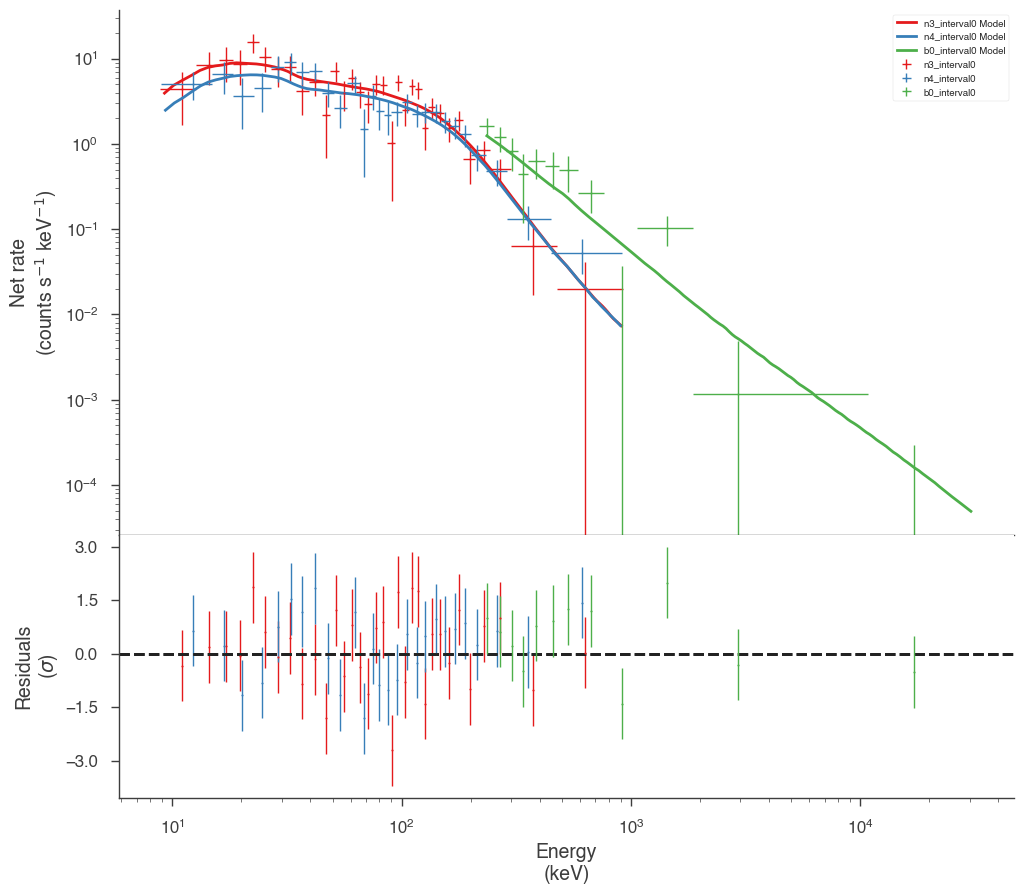

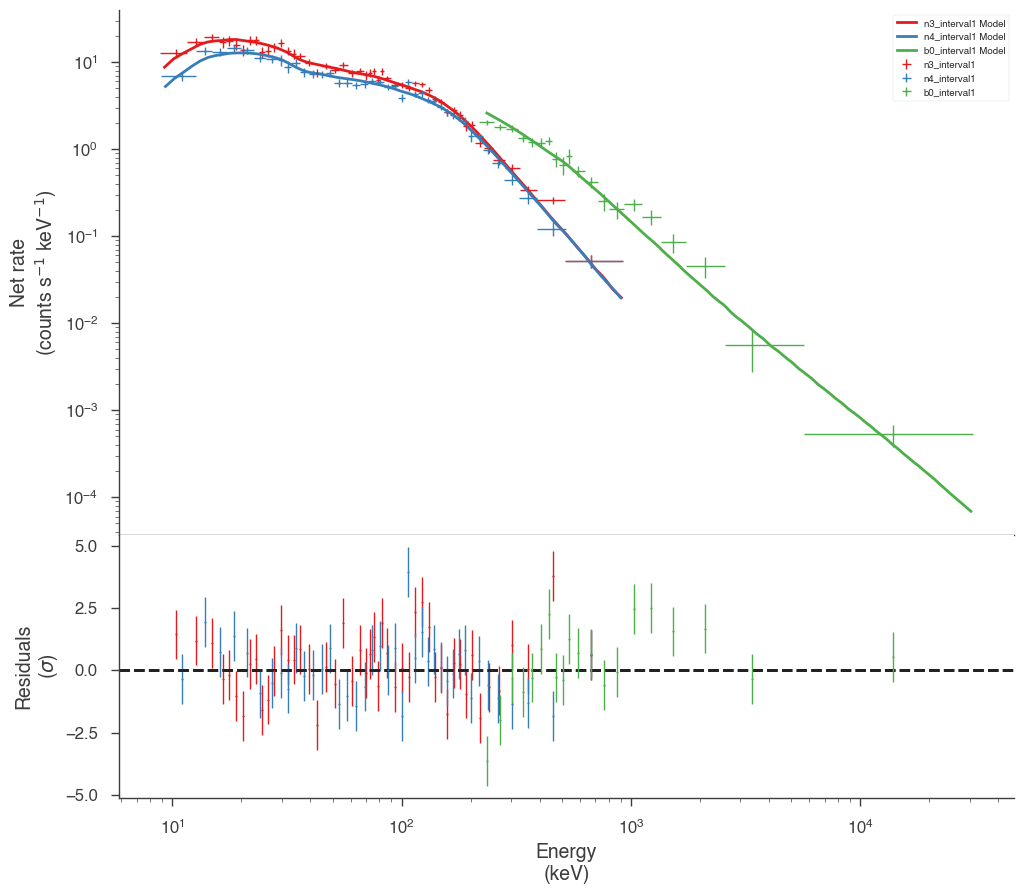

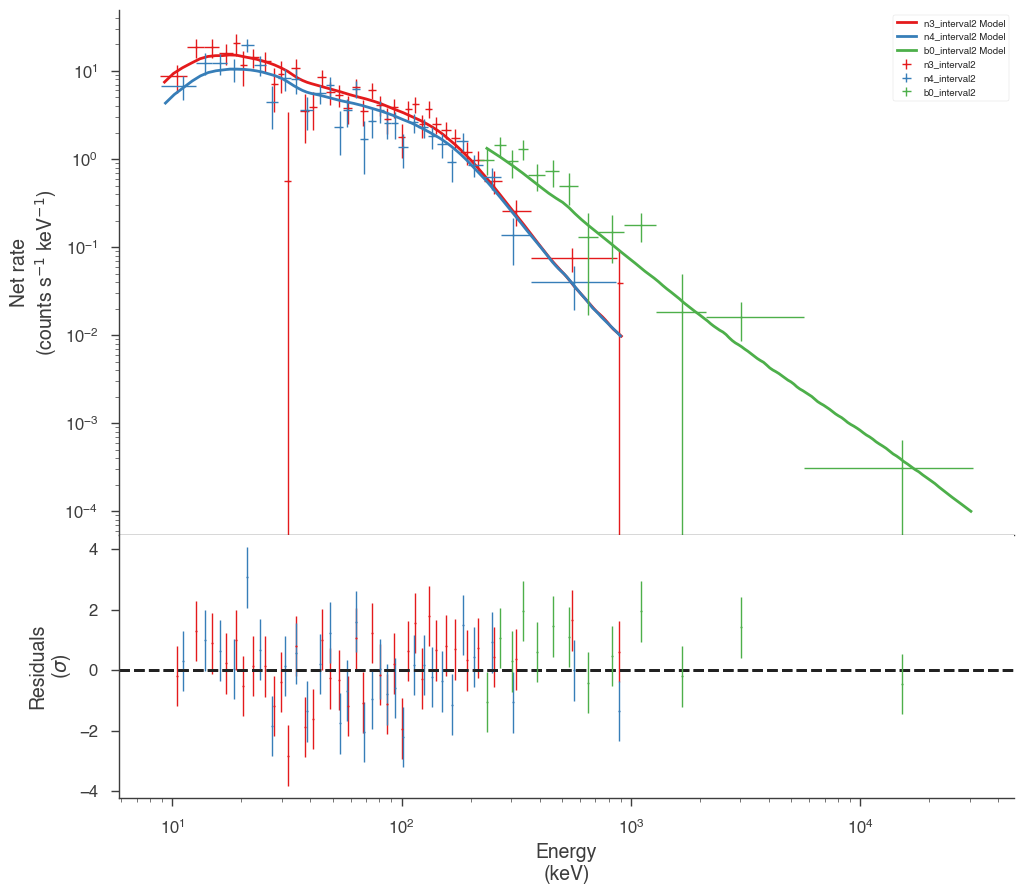

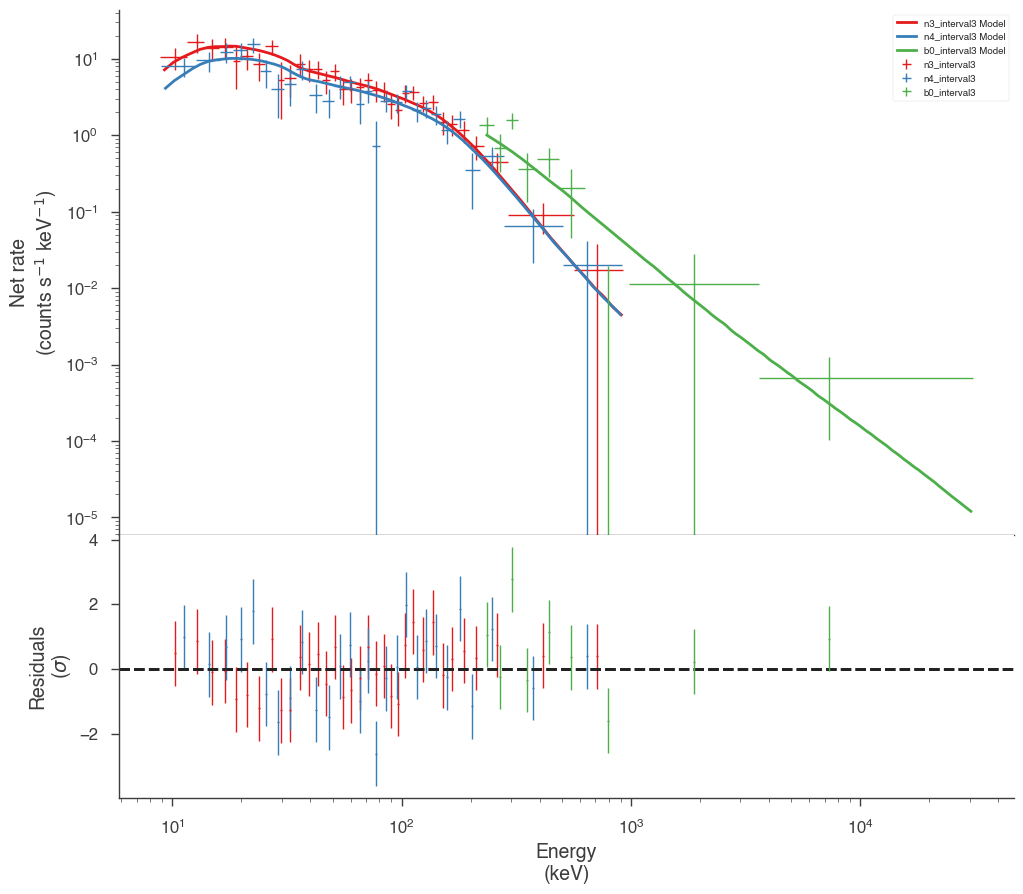

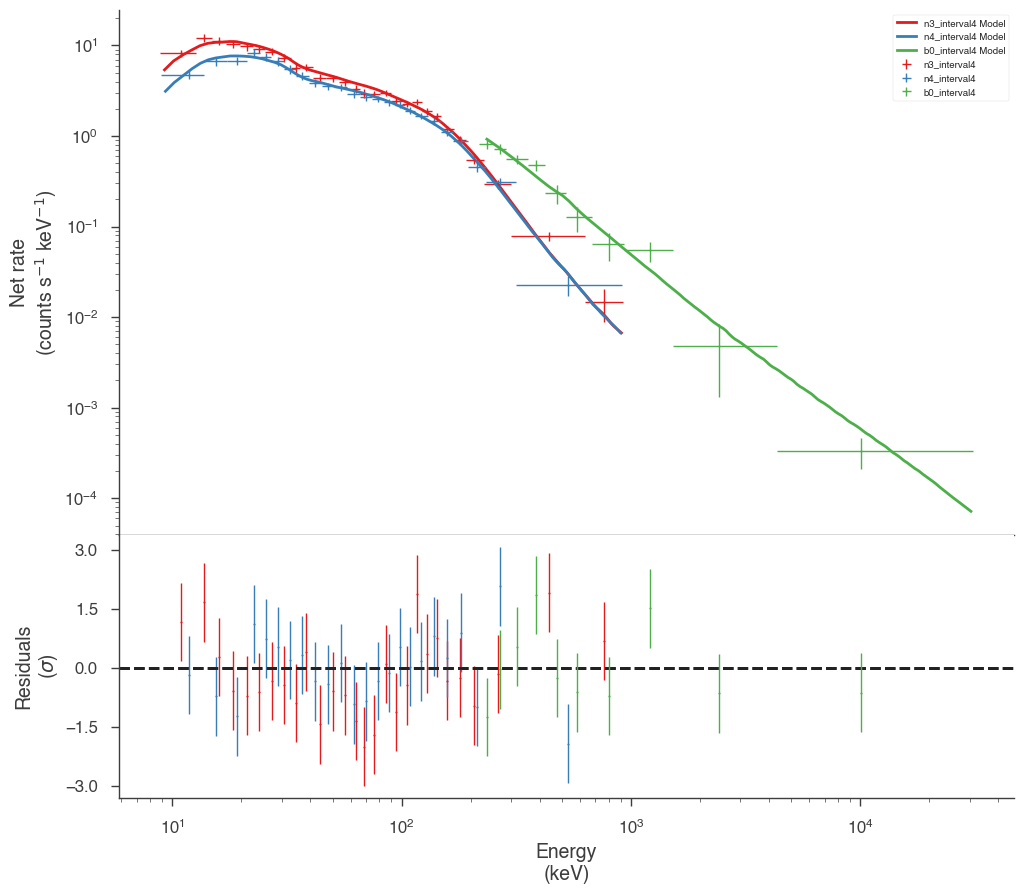

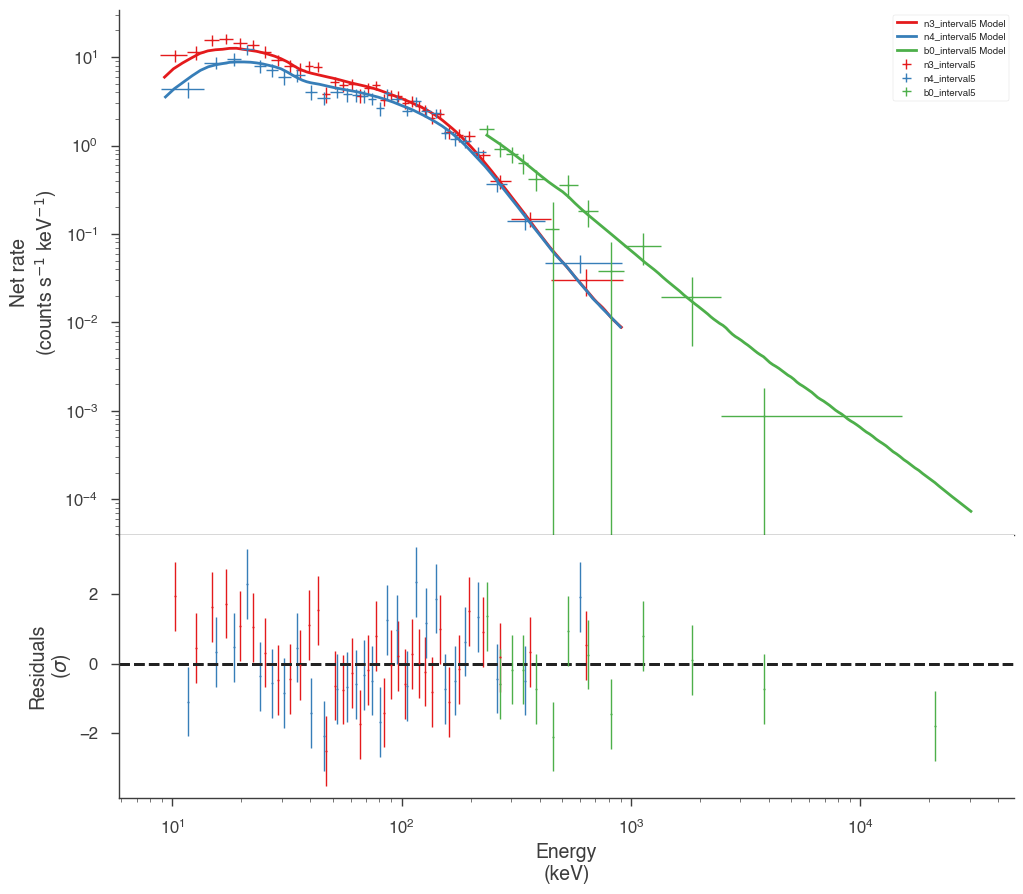

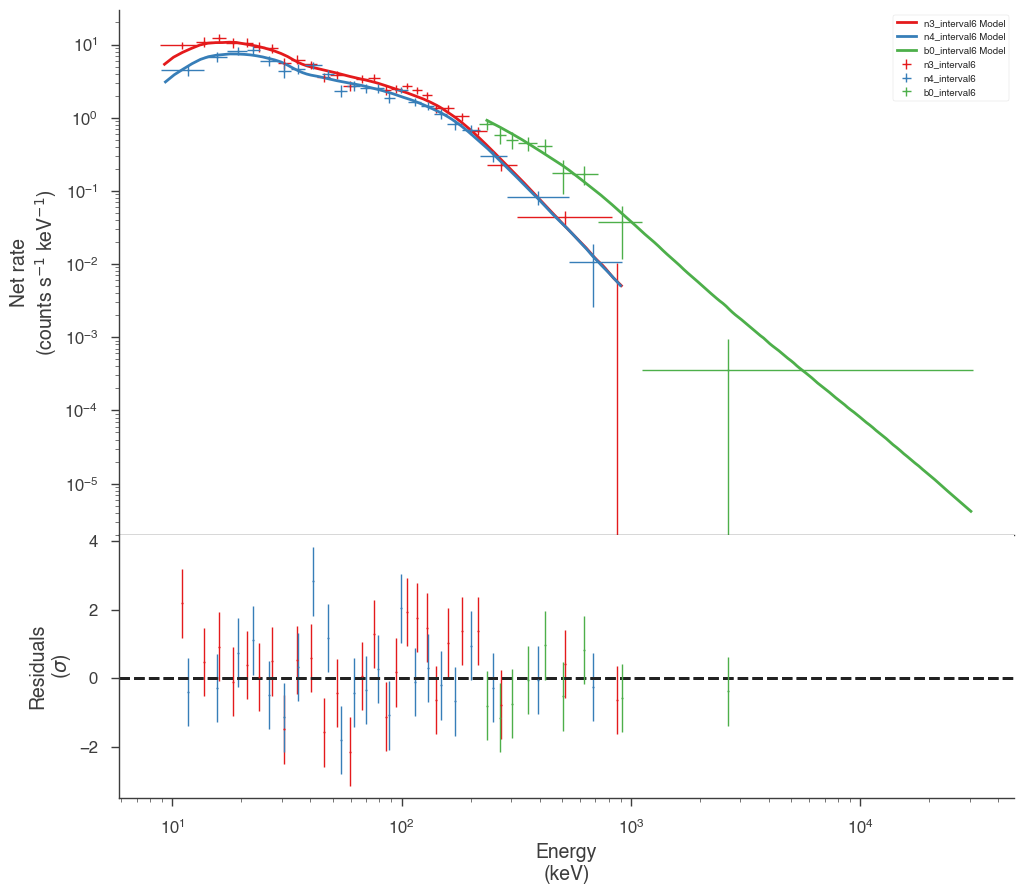

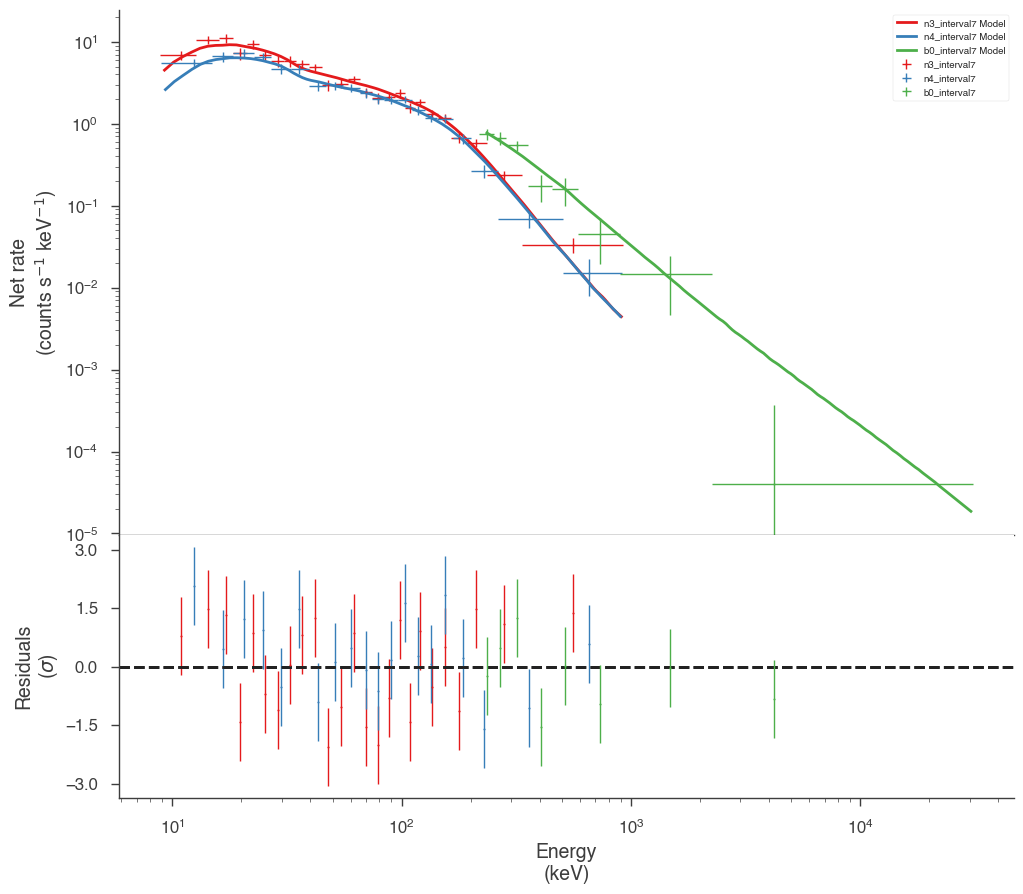

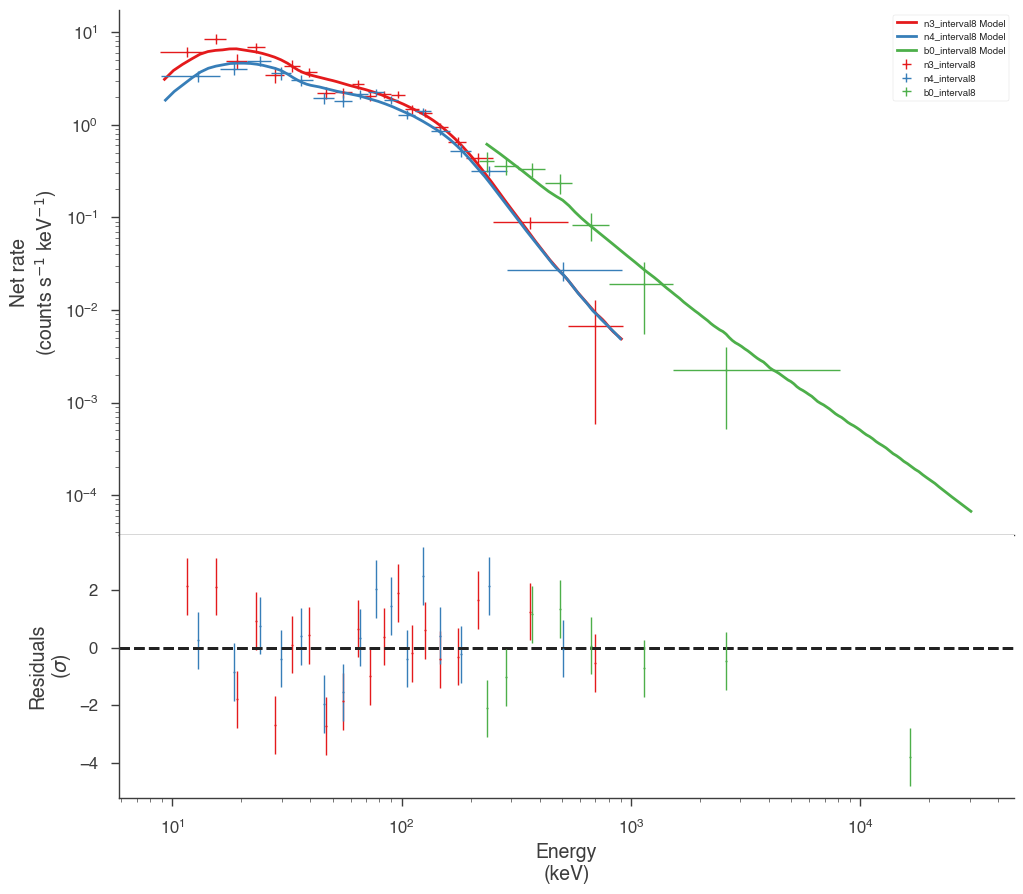

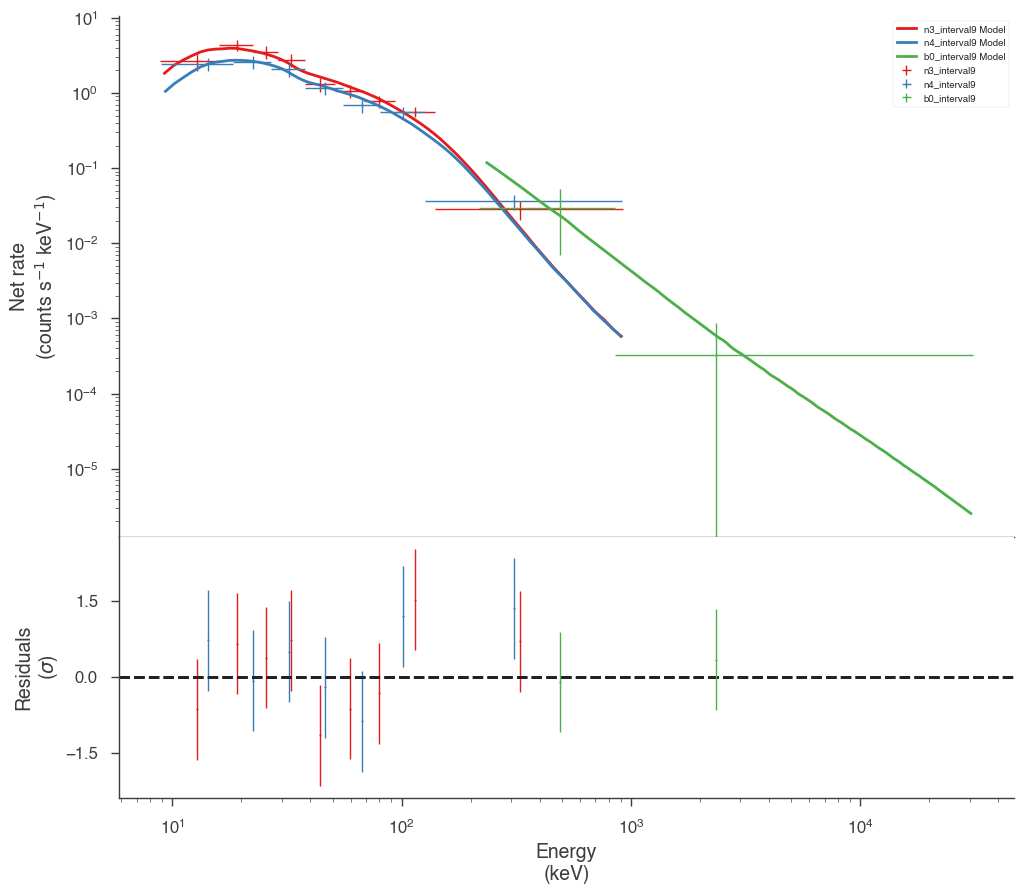

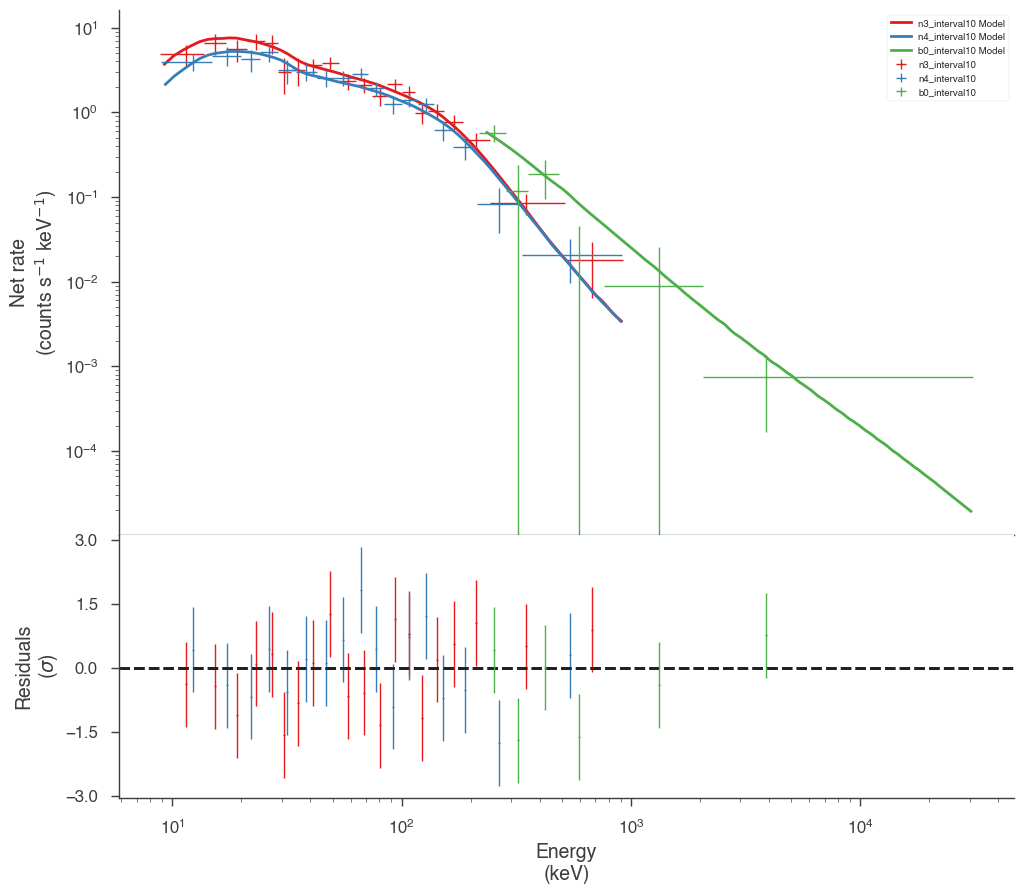

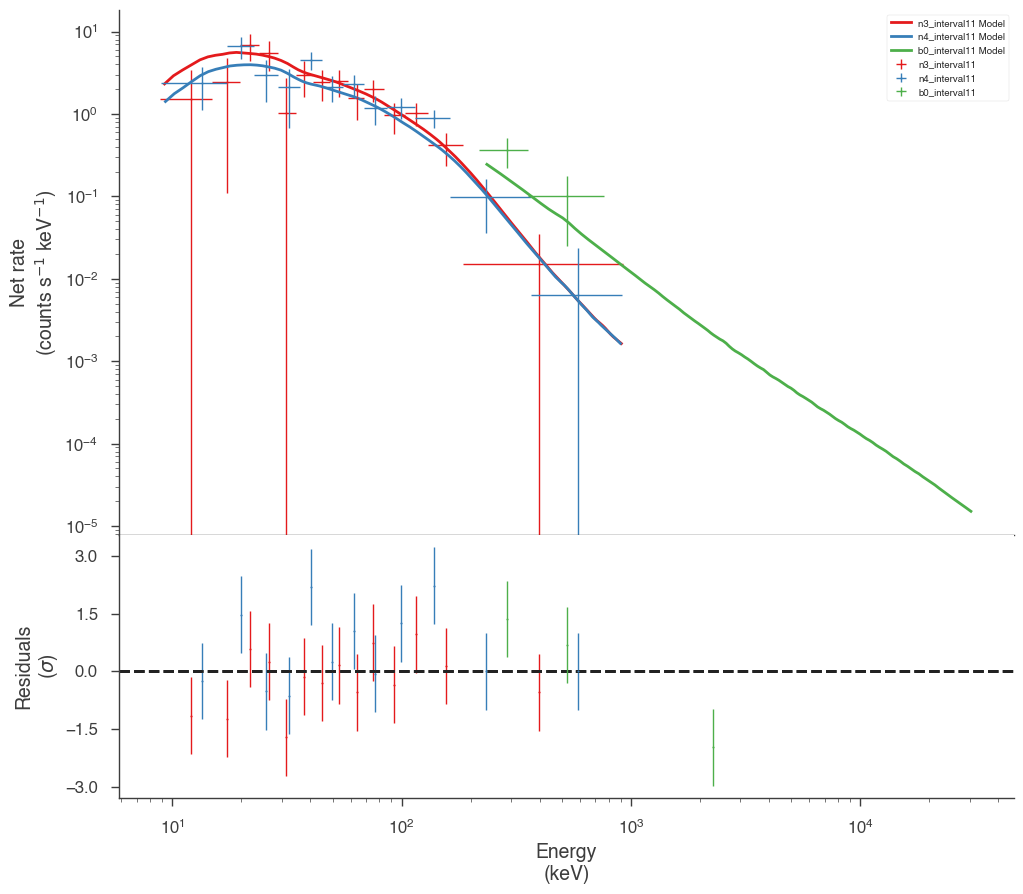

In [24]:
for a in analysis:
    a.restore_median_fit()
    _ = display_spectrum_model_counts(a, min_rate=[20, 20, 20], step=False)

Finally, we can plot the models together to see how the spectra evolve with time.

processing Bayesian analyses:   0%|          | 0/12 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

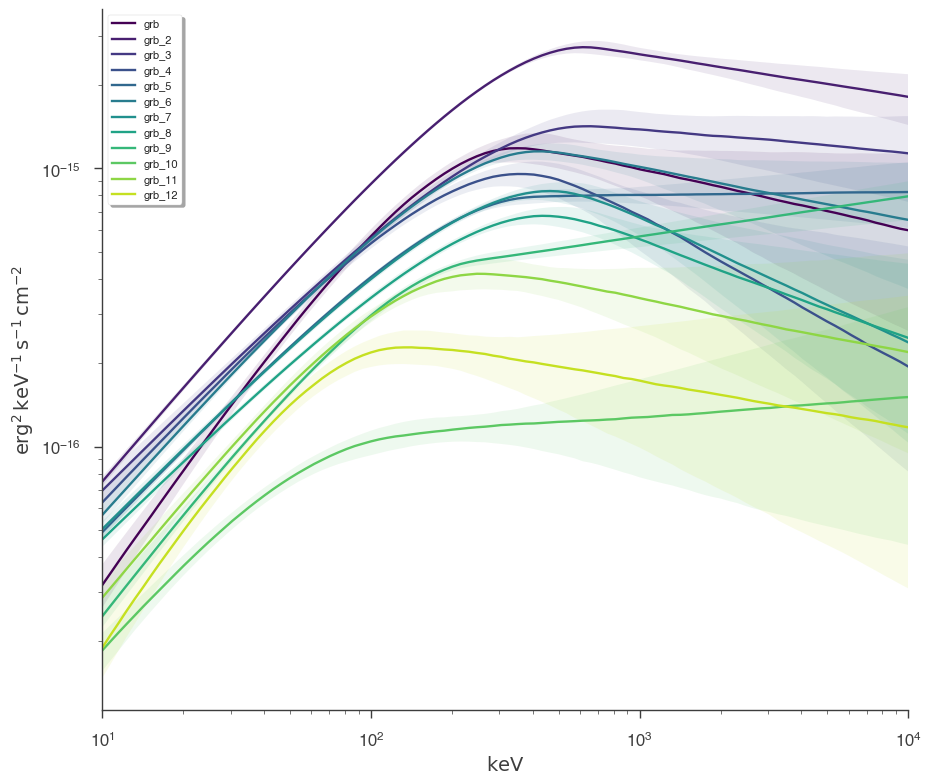

In [25]:
fig = plot_spectra(
    *[a.results for a in analysis[::1]],
    flux_unit="erg2/(cm2 s keV)",
    fit_cmap="viridis",
    contour_cmap="viridis",
    contour_style_kwargs=dict(alpha=0.1),
)

This example can serve as a template for performing analysis on GBM data. However, as 3ML provides an abstract interface and modular building blocks, similar analysis pipelines can be built for any time series data.